# FEM Application
After developing the theory for a Finite Element Method in *Theory_FEM.ipynb*, we present a small implementation of what such a simulation might look like.



In [3]:
# Import the necessary libraries
from fem import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


# Control variables
# These are the variables that control our simulation.
bounds  = [(0,1),(0,1)]         # Domain bounds
h       = 1e-2                  # Mesh Fineness parameter
FF      = lambda r,z: abs(1.3*r)    # Discretisation function
dt      = 1e-1                  # Simulation time step  

# Define a Source function
# f0      = lambda r,z,t: np.exp(-((z-v*t)**2 + r**2)/a -(t-t0)**2/b)
# f       = lambda r,z,t: f(r,z,t)* ( (2*v/a*(z-t*v) -2/b *(t-t0))**2 - (2/b+2*v*2/a))
f0      = lambda r,z,t: np.exp(-((z-v*t)**2 + r**2)/a)
f       = lambda r,z,t: a*f0(r,z,t)* ( (2*v/a*(z-t*v))**2 - (2*v*2/a))/10 * (1/(1+np.exp(-20*(t-0.2))))
v       = 1.5e-0                  # Source wave speed
a       = 1e-2                  # Source std
b       = 2e-1                  # Source offset
# t0      = 

# Now we will get the mesh and points
points,mesh = get_mesh(h,FF,bounds)
boundary    = get_boundary(points)

# Buld T, S matrices
T,S = get_TS(points,mesh)

# Construct the scheme matrix and apply boundary conditions
Ap= get_scheme_matrix(dt,T,S)
A = set_bc_lhs(boundary,Ap,points,mesh)

# Define the initial condition vectors
# Goal is to solve for U_next, using U_curr and U_prev
ff = lambda r,z: np.exp(-((z-0.5)**2 + (r)**2)/s)
# U_curr = np.array([ff(*p) for p in points])
# U_prev = np.array([0.1*ff(*p) for p in points])
U_curr = np.zeros(len(points))
U_prev = np.zeros(len(points))
F      = np.array([f(*point,0) for point in points])

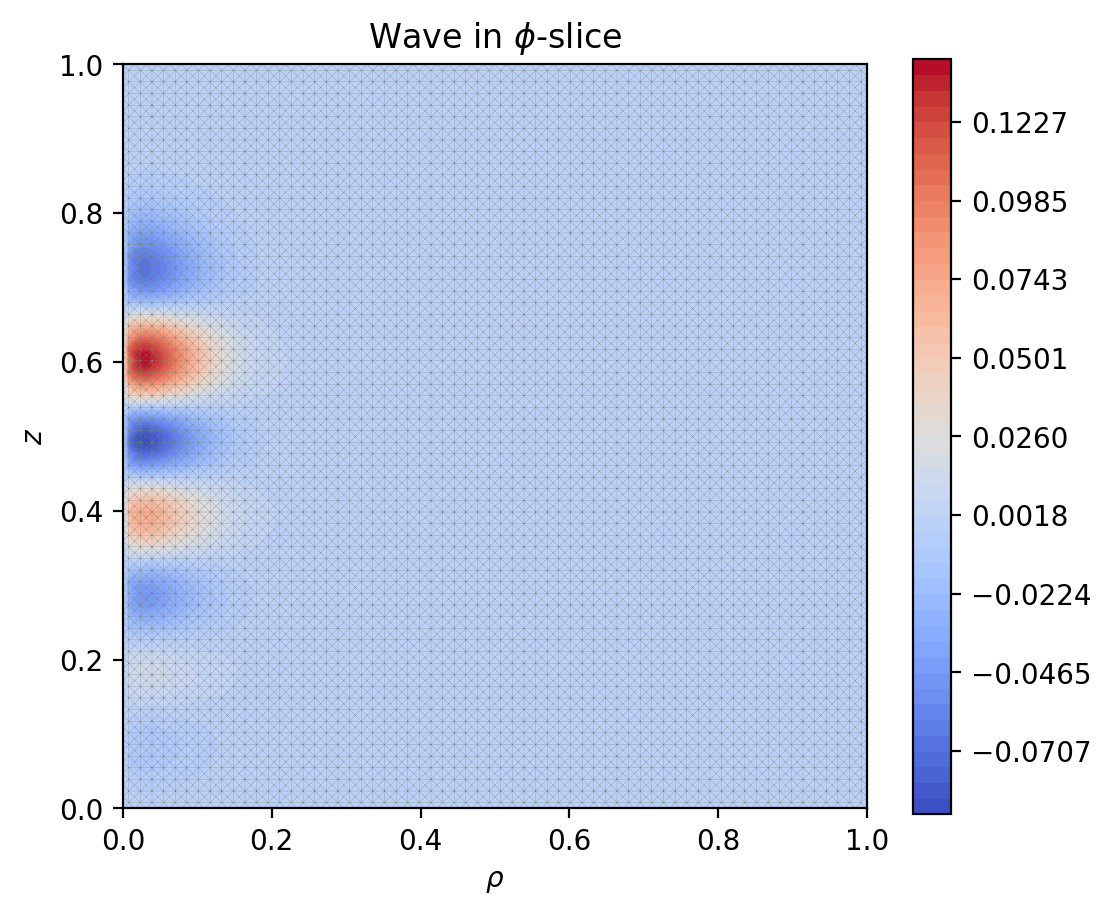

In [14]:
# Let's take one step in time and plot
# U = step(dt,A,S,T,U_curr,U_prev,F)

# U = run(2,dt,A,S,T,U_curr,U_prev,f,points);

t = 0.5
# Get the number of iterations
N = int(t//dt)
Ff = []
# Display a progress bar for fun
for i in range(N):
    Ff = get_F(f,i*dt,points)
    U_curr, U_prev = step(dt,A,S,T,U_curr,U_prev,Ff)

plot_U(points,mesh,U_curr)

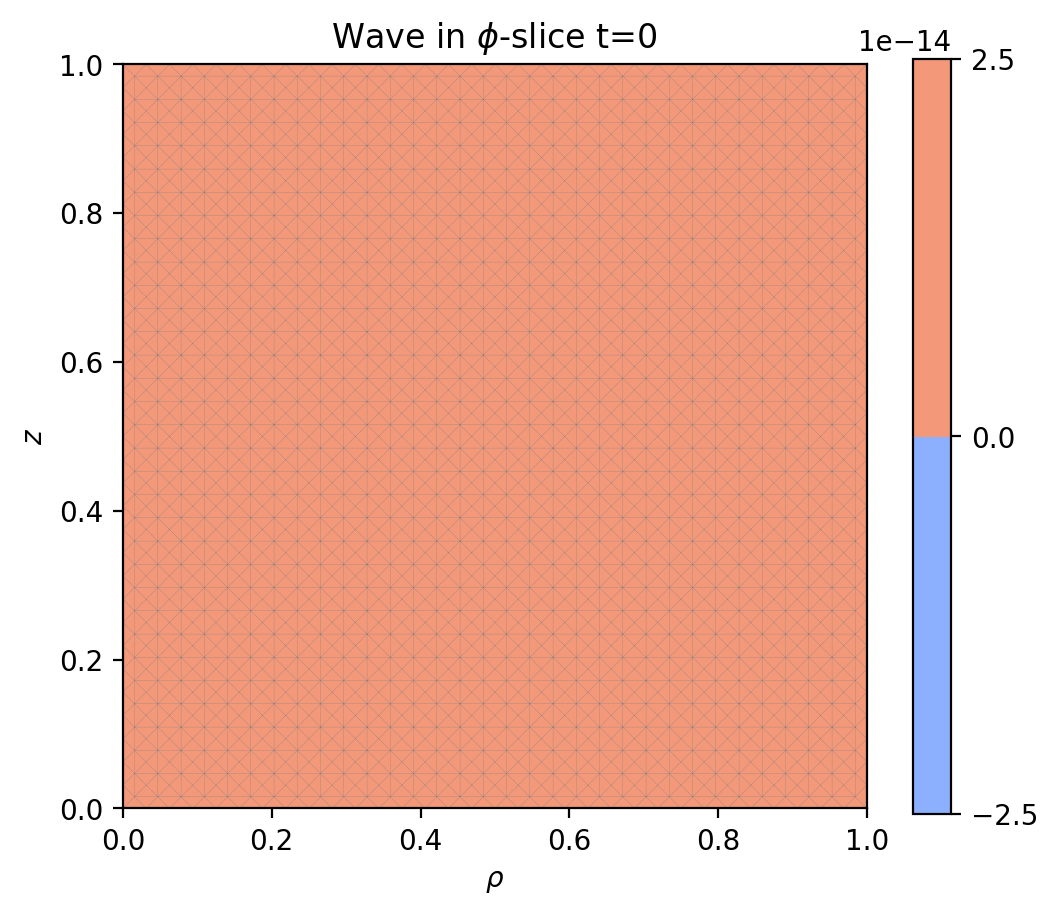

In [5]:
# Let's create an animation
# Create the figure
fig = plt.figure(figsize=(6,5),dpi=200)
ax  = fig.add_subplot(111)
ax.set_aspect('equal')
ax.set_title(r'Wave in $\phi$-slice t=0')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$z$')

# Plot the grid and the wave on top of it.
ax.triplot(points[:,0], points[:,1], mesh.simplices,lw=0.1,c='grey')
# clev = np.linspace(U_curr.min(),U_curr.max(),49)
cf = ax.tricontourf(points[:,0], points[:,1], mesh.simplices,U_curr,cmap=cm.coolwarm)
fig.colorbar(cf)

def animate(i):
    global U_prev,U_curr,F,cf,ax

    F = get_F(f,i*dt,points)
    # Calculate the left hand side
    B = get_rhs(dt,S,T,U_curr,U_prev,F)

    # move one step
    U_prev = U_curr.copy()
    U_curr = spsolve(A,B)

    # Update the plot
    for c in cf.collections:
        c.remove()
    
    clev = np.linspace(U_curr.min(),U_curr.max(),49)
    cf = ax.tricontourf(points[:,0], points[:,1], mesh.simplices,U_curr,levels=clev,cmap=cm.coolwarm)

    ax.set_title(r'Wave in $\phi$-slice t=%.2e'%(i*dt))

    return cf

anim = animation.FuncAnimation(fig, animate, frames=10, repeat=False)

In [ ]:
anim.save('animation.mp4', writer=animation.FFMpegWriter())


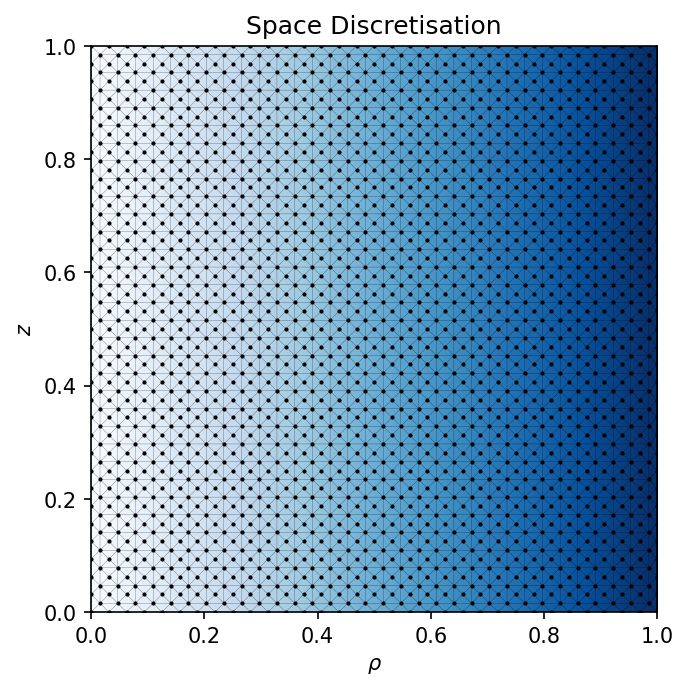

In [2]:
# Now let's print some stuff before we start solving.A
# Firstly the mesh.
plot_mesh(points,mesh,FF);

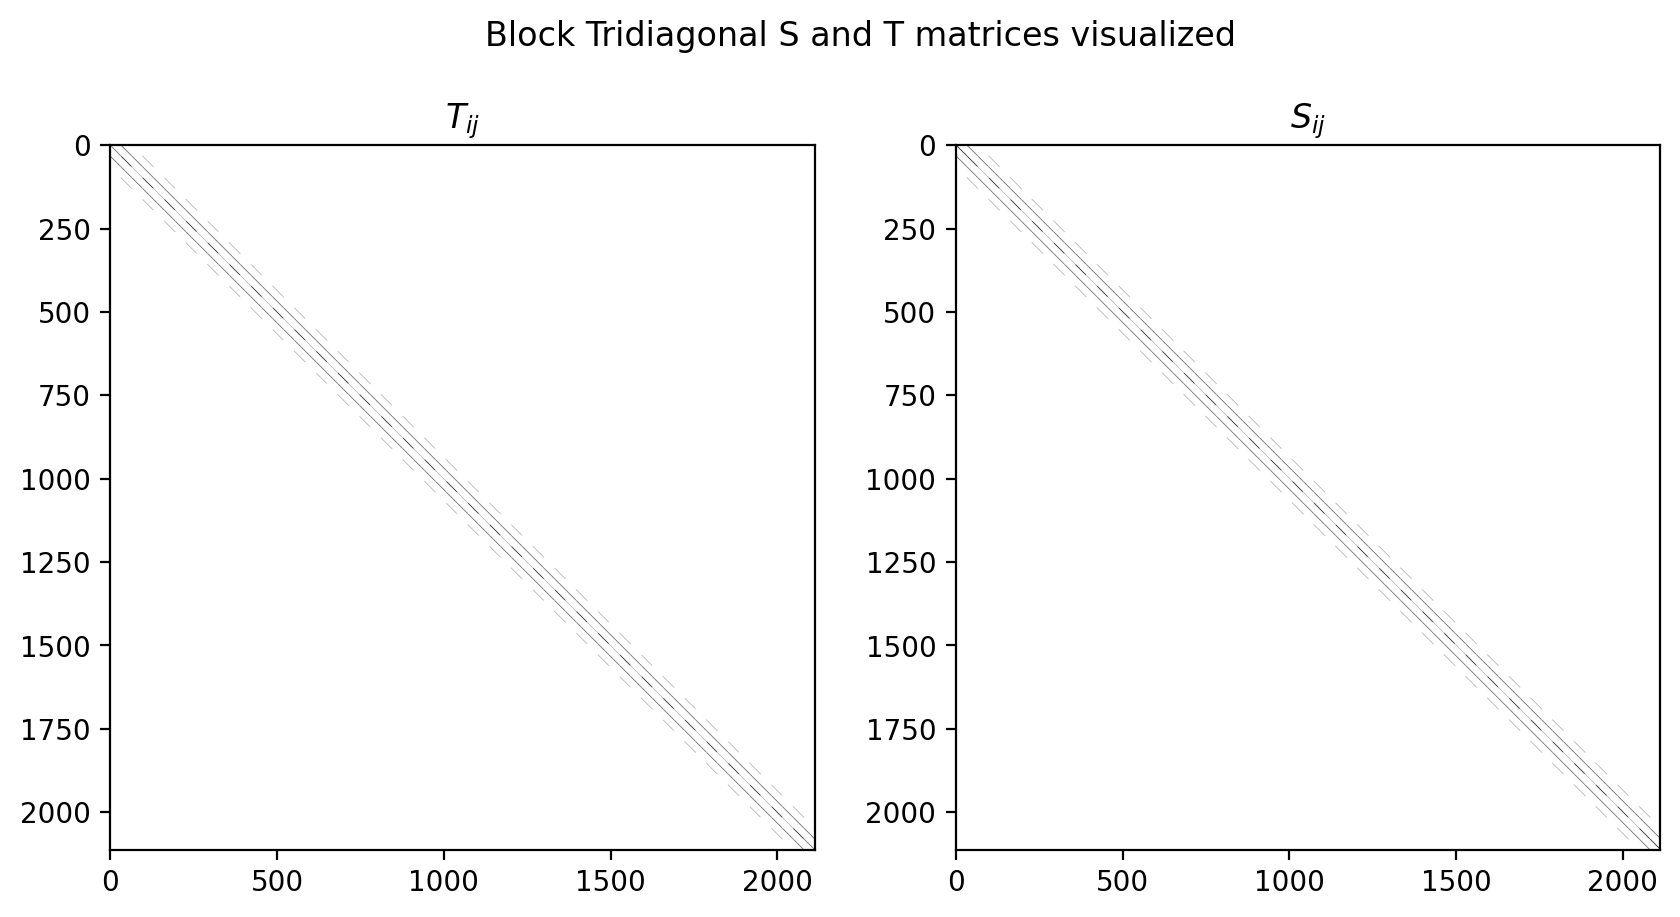

In [13]:
# Now let's plto the T,S Matrices
plot_TS(T,S);

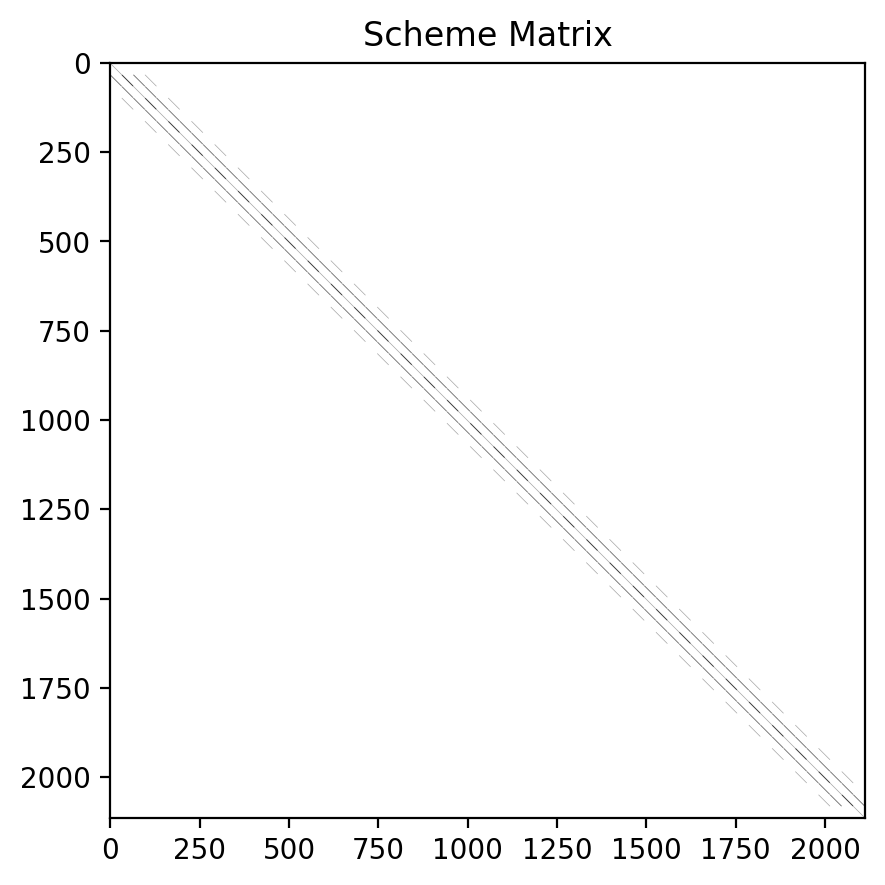

In [14]:
# Plotting the A matrix
plot_A(Ap);